In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 150
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
pcmciplus_features = ['LW_down', 'snowfall', 'sst', 'sosaline', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

,Day,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
7305,1/1/1999,4.987515,0.891843,183.786092,1.120906,0.700735,0.501109,33.316996,273.467869,250.884060,985.112721,13823248
7306,1/2/1999,5.075952,0.905535,183.851814,1.193514,0.712730,0.482221,33.316996,273.453826,250.359328,984.092282,13885522
7307,1/3/1999,4.931520,0.911672,184.426913,1.263909,0.677339,0.480718,33.316996,273.454385,250.327500,982.300080,13884279
7308,1/4/1999,4.761644,0.911301,187.528326,1.269229,0.824016,0.697950,33.316996,273.459797,249.905730,983.250565,13912624
7309,1/5/1999,4.739850,0.901353,187.326709,1.552208,0.926681,0.835868,33.316996,273.463975,250.254873,984.247389,13890148


In [4]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
# df = df[pcmciplus_features]
# df.tail(len(df))

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + lead_time])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

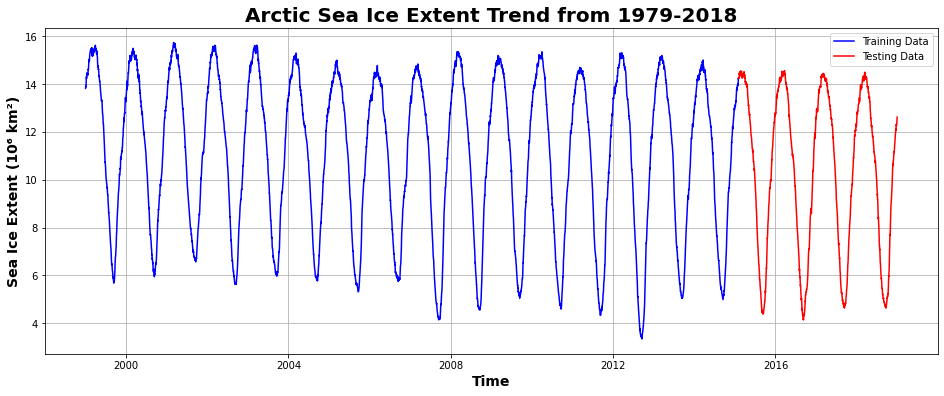

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14784     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 121,921
Trainable params: 121,921
Non-trai

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.0209 - mae: 0.1065 - mse: 0.0209

81/81 [==============================] - 9s 19ms/step - loss: 0.0209 - mae: 0.1065 - mse: 0.0209 - val_loss: 0.0025 - val_mae: 0.0385 - val_mse: 0.0025
Epoch 2/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0073 - mae: 0.0673 - mse: 0.0073

81/81 [==============================] - 1s 8ms/step - loss: 0.0073 - mae: 0.0673 - mse: 0.0073 - val_loss: 0.0021 - val_mae: 0.0348 - val_mse: 0.0021
Epoch 3/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0060 - mae: 0.0618 - mse: 0.0060

81/81 [==============================] - 1s 8ms/step - loss: 0.0060 - mae: 0.0618 - mse: 0.0060 - val_loss: 0.0018 - val_mae: 0.0285 - val_mse: 0.0018
Epoch 4/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0049 - mae: 0.0557 - mse: 0.0049

81/81 [==============================] - 1s 8ms/step - loss: 0.0049 - mae: 0.0555 - mse: 0.0049 - val_loss: 0.0010 - val_mae: 0.0252 - val_mse: 0.0010
Epoch 5/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0050 - mae: 0.0559 - mse: 0.0050

81/81 [==============================] - 1s 8ms/step - loss: 0.0049 - mae: 0.0557 - mse: 0.0049 - val_loss: 0.0015 - val_mae: 0.0305 - val_mse: 0.0015
Epoch 6/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0043 - mae: 0.0517 - mse: 0.0043

81/81 [==============================] - 1s 8ms/step - loss: 0.0043 - mae: 0.0517 - mse: 0.0043 - val_loss: 8.9278e-04 - val_mae: 0.0250 - val_mse: 8.9278e-04
Epoch 7/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0037 - mae: 0.0477 - mse: 0.0037

81/81 [==============================] - 1s 8ms/step - loss: 0.0036 - mae: 0.0475 - mse: 0.0036 - val_loss: 8.7639e-04 - val_mae: 0.0227 - val_mse: 8.7639e-04
Epoch 8/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0038 - mae: 0.0481 - mse: 0.0038

81/81 [==============================] - 1s 8ms/step - loss: 0.0037 - mae: 0.0479 - mse: 0.0037 - val_loss: 9.6749e-04 - val_mae: 0.0239 - val_mse: 9.6749e-04
Epoch 9/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0034 - mae: 0.0455 - mse: 0.0034

81/81 [==============================] - 1s 8ms/step - loss: 0.0034 - mae: 0.0453 - mse: 0.0034 - val_loss: 0.0011 - val_mae: 0.0269 - val_mse: 0.0011
Epoch 10/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0032 - mae: 0.0446 - mse: 0.0032

81/81 [==============================] - 1s 8ms/step - loss: 0.0032 - mae: 0.0446 - mse: 0.0032 - val_loss: 9.6740e-04 - val_mae: 0.0260 - val_mse: 9.6740e-04
Epoch 11/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0034 - mae: 0.0457 - mse: 0.0034

81/81 [==============================] - 1s 8ms/step - loss: 0.0034 - mae: 0.0455 - mse: 0.0034 - val_loss: 0.0013 - val_mae: 0.0312 - val_mse: 0.0013
Epoch 12/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0437 - mse: 0.0031

81/81 [==============================] - 1s 8ms/step - loss: 0.0031 - mae: 0.0438 - mse: 0.0031 - val_loss: 0.0014 - val_mae: 0.0292 - val_mse: 0.0014
Epoch 13/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0030 - mae: 0.0424 - mse: 0.0030

81/81 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0424 - mse: 0.0030 - val_loss: 0.0026 - val_mae: 0.0431 - val_mse: 0.0026
Epoch 14/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0028 - mae: 0.0414 - mse: 0.0028

81/81 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0416 - mse: 0.0028 - val_loss: 0.0019 - val_mae: 0.0386 - val_mse: 0.0019
Epoch 15/100
79/81 [============================>.] - ETA: 0s - loss: 0.0030 - mae: 0.0421 - mse: 0.0030

81/81 [==============================] - 1s 8ms/step - loss: 0.0029 - mae: 0.0420 - mse: 0.0029 - val_loss: 0.0013 - val_mae: 0.0262 - val_mse: 0.0013
Epoch 16/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0399 - mse: 0.0027

81/81 [==============================] - 1s 8ms/step - loss: 0.0027 - mae: 0.0400 - mse: 0.0027 - val_loss: 0.0018 - val_mae: 0.0366 - val_mse: 0.0018
Epoch 17/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0393 - mse: 0.0026

81/81 [==============================] - 1s 8ms/step - loss: 0.0026 - mae: 0.0394 - mse: 0.0026 - val_loss: 0.0022 - val_mae: 0.0383 - val_mse: 0.0022
Epoch 18/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0028 - mae: 0.0405 - mse: 0.0028

81/81 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0407 - mse: 0.0028 - val_loss: 0.0027 - val_mae: 0.0444 - val_mse: 0.0027
Epoch 19/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0391 - mse: 0.0025

81/81 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0390 - mse: 0.0025 - val_loss: 0.0012 - val_mae: 0.0259 - val_mse: 0.0012
Epoch 20/100
79/81 [============================>.] - ETA: 0s - loss: 0.0026 - mae: 0.0395 - mse: 0.0026

81/81 [==============================] - 1s 8ms/step - loss: 0.0026 - mae: 0.0395 - mse: 0.0026 - val_loss: 0.0014 - val_mae: 0.0310 - val_mse: 0.0014
Epoch 21/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0370 - mse: 0.0023

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0371 - mse: 0.0023 - val_loss: 0.0015 - val_mae: 0.0314 - val_mse: 0.0015
Epoch 22/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0378 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0378 - mse: 0.0024 - val_loss: 0.0011 - val_mae: 0.0264 - val_mse: 0.0011
Epoch 23/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0374 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0374 - mse: 0.0024 - val_loss: 0.0015 - val_mae: 0.0311 - val_mse: 0.0015
Epoch 24/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0378 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0380 - mse: 0.0024 - val_loss: 0.0022 - val_mae: 0.0313 - val_mse: 0.0022
Epoch 25/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0369 - mse: 0.0023

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0369 - mse: 0.0023 - val_loss: 0.0014 - val_mae: 0.0260 - val_mse: 0.0014
Epoch 26/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0361 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0360 - mse: 0.0022 - val_loss: 0.0031 - val_mae: 0.0477 - val_mse: 0.0031
Epoch 27/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0369 - mse: 0.0023

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0368 - mse: 0.0023 - val_loss: 7.1919e-04 - val_mae: 0.0216 - val_mse: 7.1919e-04
Epoch 28/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0360 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0360 - mse: 0.0022 - val_loss: 0.0013 - val_mae: 0.0298 - val_mse: 0.0013
Epoch 29/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0021 - mae: 0.0354 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0353 - mse: 0.0021 - val_loss: 0.0018 - val_mae: 0.0296 - val_mse: 0.0018
Epoch 30/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0368 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0367 - mse: 0.0024 - val_loss: 0.0016 - val_mae: 0.0296 - val_mse: 0.0016
Epoch 31/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0351 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0352 - mse: 0.0021 - val_loss: 0.0010 - val_mae: 0.0267 - val_mse: 0.0010
Epoch 32/100
81/81 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0354 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0354 - mse: 0.0021 - val_loss: 0.0012 - val_mae: 0.0272 - val_mse: 0.0012
Epoch 33/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0345 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0347 - mse: 0.0021 - val_loss: 0.0012 - val_mae: 0.0285 - val_mse: 0.0012
Epoch 34/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0341 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0341 - mse: 0.0020 - val_loss: 0.0017 - val_mae: 0.0315 - val_mse: 0.0017
Epoch 35/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0344 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0344 - mse: 0.0020 - val_loss: 0.0018 - val_mae: 0.0292 - val_mse: 0.0018
Epoch 36/100
80/81 [============================>.] - ETA: 0s - loss: 0.0022 - mae: 0.0358 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0358 - mse: 0.0022 - val_loss: 0.0011 - val_mae: 0.0244 - val_mse: 0.0011
Epoch 37/100
81/81 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0347 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0347 - mse: 0.0021 - val_loss: 0.0020 - val_mae: 0.0363 - val_mse: 0.0020
Epoch 38/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0021 - mae: 0.0351 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0353 - mse: 0.0021 - val_loss: 0.0012 - val_mae: 0.0276 - val_mse: 0.0012
Epoch 39/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0336 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0337 - mse: 0.0020 - val_loss: 0.0016 - val_mae: 0.0314 - val_mse: 0.0016
Epoch 40/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0343 - mse: 0.0020

81/81 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0342 - mse: 0.0020 - val_loss: 0.0018 - val_mae: 0.0334 - val_mse: 0.0018
Epoch 41/100
81/81 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0326 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0326 - mse: 0.0018 - val_loss: 0.0014 - val_mae: 0.0300 - val_mse: 0.0014
Epoch 42/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0318 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0318 - mse: 0.0018 - val_loss: 0.0023 - val_mae: 0.0380 - val_mse: 0.0023
Epoch 43/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0019 - mae: 0.0334 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0333 - mse: 0.0019 - val_loss: 0.0014 - val_mae: 0.0300 - val_mse: 0.0014
Epoch 44/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0322 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0322 - mse: 0.0018 - val_loss: 0.0020 - val_mae: 0.0369 - val_mse: 0.0020
Epoch 45/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0326 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0327 - mse: 0.0019 - val_loss: 0.0015 - val_mae: 0.0295 - val_mse: 0.0015
Epoch 46/100
79/81 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0314 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0314 - mse: 0.0017 - val_loss: 0.0024 - val_mae: 0.0392 - val_mse: 0.0024
Epoch 47/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0320 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0320 - mse: 0.0018 - val_loss: 0.0022 - val_mae: 0.0360 - val_mse: 0.0022
Epoch 48/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0320 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0320 - mse: 0.0018 - val_loss: 0.0018 - val_mae: 0.0319 - val_mse: 0.0018
Epoch 49/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0315 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0317 - mse: 0.0017 - val_loss: 0.0023 - val_mae: 0.0400 - val_mse: 0.0023
Epoch 50/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0316 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0315 - mse: 0.0017 - val_loss: 0.0016 - val_mae: 0.0322 - val_mse: 0.0016
Epoch 51/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0017 - mae: 0.0320 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0321 - mse: 0.0017 - val_loss: 0.0026 - val_mae: 0.0436 - val_mse: 0.0026
Epoch 52/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0333 - mse: 0.0019

81/81 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0332 - mse: 0.0019 - val_loss: 0.0021 - val_mae: 0.0360 - val_mse: 0.0021
Epoch 53/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0306 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0306 - mse: 0.0016 - val_loss: 0.0015 - val_mae: 0.0295 - val_mse: 0.0015
Epoch 54/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0016 - mae: 0.0305 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0304 - mse: 0.0016 - val_loss: 0.0020 - val_mae: 0.0326 - val_mse: 0.0020
Epoch 55/100
80/81 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0288 - mse: 0.0014

81/81 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 0.0028 - val_mae: 0.0429 - val_mse: 0.0028
Epoch 56/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0322 - mse: 0.0018

81/81 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0321 - mse: 0.0018 - val_loss: 0.0018 - val_mae: 0.0312 - val_mse: 0.0018
Epoch 57/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0016 - mae: 0.0302 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0302 - mse: 0.0016 - val_loss: 0.0021 - val_mae: 0.0381 - val_mse: 0.0021
Epoch 58/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0309 - mse: 0.0016

81/81 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0310 - mse: 0.0016 - val_loss: 0.0024 - val_mae: 0.0394 - val_mse: 0.0024
Epoch 59/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0292 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 0.0031 - val_mae: 0.0481 - val_mse: 0.0031
Epoch 60/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0296 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0296 - mse: 0.0015 - val_loss: 0.0017 - val_mae: 0.0327 - val_mse: 0.0017
Epoch 61/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0298 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0298 - mse: 0.0015 - val_loss: 0.0013 - val_mae: 0.0291 - val_mse: 0.0013
Epoch 62/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0287 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0287 - mse: 0.0014 - val_loss: 0.0021 - val_mae: 0.0378 - val_mse: 0.0021
Epoch 63/100
79/81 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0293 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 0.0013 - val_mae: 0.0294 - val_mse: 0.0013
Epoch 64/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0284 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0284 - mse: 0.0014 - val_loss: 0.0022 - val_mae: 0.0385 - val_mse: 0.0022
Epoch 65/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0300 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0299 - mse: 0.0015 - val_loss: 0.0020 - val_mae: 0.0364 - val_mse: 0.0020
Epoch 66/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0286 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 0.0019 - val_mae: 0.0356 - val_mse: 0.0019
Epoch 67/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0287 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 0.0023 - val_mae: 0.0410 - val_mse: 0.0023
Epoch 68/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0269 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0269 - mse: 0.0012 - val_loss: 0.0019 - val_mae: 0.0357 - val_mse: 0.0019
Epoch 69/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0265 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0266 - mse: 0.0012 - val_loss: 0.0021 - val_mae: 0.0349 - val_mse: 0.0021
Epoch 70/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0291 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0291 - mse: 0.0014 - val_loss: 0.0014 - val_mae: 0.0292 - val_mse: 0.0014
Epoch 71/100
80/81 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0295 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0294 - mse: 0.0014 - val_loss: 0.0017 - val_mae: 0.0340 - val_mse: 0.0017
Epoch 72/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0273 - mse: 0.0013 - val_loss: 0.0025 - val_mae: 0.0423 - val_mse: 0.0025
Epoch 73/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0264 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0263 - mse: 0.0011 - val_loss: 0.0015 - val_mae: 0.0311 - val_mse: 0.0015
Epoch 74/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 0.0021 - val_mae: 0.0381 - val_mse: 0.0021
Epoch 75/100
80/81 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0249 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 0.0032 - val_mae: 0.0455 - val_mse: 0.0032
Epoch 76/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0251 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0252 - mse: 0.0010 - val_loss: 0.0013 - val_mae: 0.0288 - val_mse: 0.0013
Epoch 77/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0277 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0276 - mse: 0.0013 - val_loss: 0.0026 - val_mae: 0.0424 - val_mse: 0.0026
Epoch 78/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0271 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0271 - mse: 0.0012 - val_loss: 0.0026 - val_mae: 0.0401 - val_mse: 0.0026
Epoch 79/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0253 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0253 - mse: 0.0010 - val_loss: 0.0023 - val_mae: 0.0398 - val_mse: 0.0023
Epoch 80/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0269 - mse: 0.0012

81/81 [==============================] - 1s 7ms/step - loss: 0.0012 - mae: 0.0268 - mse: 0.0012 - val_loss: 0.0023 - val_mae: 0.0381 - val_mse: 0.0023
Epoch 81/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0249 - mse: 0.0010        

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 0.0022 - val_mae: 0.0336 - val_mse: 0.0022
Epoch 82/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0252 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0250 - mse: 0.0010 - val_loss: 0.0019 - val_mae: 0.0371 - val_mse: 0.0019
Epoch 83/100
80/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0261 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0262 - mse: 0.0011 - val_loss: 0.0019 - val_mae: 0.0370 - val_mse: 0.0019
Epoch 84/100
78/81 [===========================>..] - ETA: 0s - loss: 9.2757e-04 - mae: 0.0240 - mse: 9.2757e-04

81/81 [==============================] - 1s 9ms/step - loss: 9.3183e-04 - mae: 0.0240 - mse: 9.3183e-04 - val_loss: 0.0019 - val_mae: 0.0336 - val_mse: 0.0019
Epoch 85/100
81/81 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0250 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0250 - mse: 0.0010 - val_loss: 0.0020 - val_mae: 0.0376 - val_mse: 0.0020
Epoch 86/100
77/81 [===========================>..] - ETA: 0s - loss: 9.5568e-04 - mae: 0.0244 - mse: 9.5568e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.5352e-04 - mae: 0.0244 - mse: 9.5352e-04 - val_loss: 0.0015 - val_mae: 0.0316 - val_mse: 0.0015
Epoch 87/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0253 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0252 - mse: 0.0011 - val_loss: 0.0020 - val_mae: 0.0364 - val_mse: 0.0020
Epoch 88/100
76/81 [===========================>..] - ETA: 0s - loss: 8.7783e-04 - mae: 0.0233 - mse: 8.7783e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.7228e-04 - mae: 0.0232 - mse: 8.7228e-04 - val_loss: 0.0019 - val_mae: 0.0355 - val_mse: 0.0019
Epoch 89/100
76/81 [===========================>..] - ETA: 0s - loss: 8.2404e-04 - mae: 0.0225 - mse: 8.2404e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.3237e-04 - mae: 0.0225 - mse: 8.3237e-04 - val_loss: 0.0021 - val_mae: 0.0362 - val_mse: 0.0021
Epoch 90/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0257 - mse: 0.0011 - val_loss: 0.0027 - val_mae: 0.0415 - val_mse: 0.0027
Epoch 91/100
74/81 [==========================>...] - ETA: 0s - loss: 9.1124e-04 - mae: 0.0238 - mse: 9.1124e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.0087e-04 - mae: 0.0237 - mse: 9.0087e-04 - val_loss: 0.0013 - val_mae: 0.0287 - val_mse: 0.0013
Epoch 92/100
78/81 [===========================>..] - ETA: 0s - loss: 7.4704e-04 - mae: 0.0215 - mse: 7.4704e-04

81/81 [==============================] - 1s 11ms/step - loss: 7.4427e-04 - mae: 0.0214 - mse: 7.4427e-04 - val_loss: 0.0017 - val_mae: 0.0341 - val_mse: 0.0017
Epoch 93/100
81/81 [==============================] - ETA: 0s - loss: 7.9237e-04 - mae: 0.0222 - mse: 7.9237e-04

81/81 [==============================] - 2s 23ms/step - loss: 7.9237e-04 - mae: 0.0222 - mse: 7.9237e-04 - val_loss: 0.0024 - val_mae: 0.0392 - val_mse: 0.0024
Epoch 94/100
81/81 [==============================] - ETA: 0s - loss: 8.2809e-04 - mae: 0.0225 - mse: 8.2809e-04

81/81 [==============================] - 1s 11ms/step - loss: 8.2809e-04 - mae: 0.0225 - mse: 8.2809e-04 - val_loss: 0.0022 - val_mae: 0.0367 - val_mse: 0.0022
Epoch 95/100
79/81 [============================>.] - ETA: 0s - loss: 8.3703e-04 - mae: 0.0227 - mse: 8.3703e-04

81/81 [==============================] - 1s 12ms/step - loss: 8.3590e-04 - mae: 0.0227 - mse: 8.3590e-04 - val_loss: 0.0038 - val_mae: 0.0518 - val_mse: 0.0038
Epoch 96/100
79/81 [============================>.] - ETA: 0s - loss: 8.1333e-04 - mae: 0.0225 - mse: 8.1333e-04

81/81 [==============================] - 1s 14ms/step - loss: 8.1058e-04 - mae: 0.0224 - mse: 8.1058e-04 - val_loss: 0.0015 - val_mae: 0.0323 - val_mse: 0.0015
Epoch 97/100
79/81 [============================>.] - ETA: 0s - loss: 7.4816e-04 - mae: 0.0214 - mse: 7.4816e-04

81/81 [==============================] - 1s 8ms/step - loss: 7.4801e-04 - mae: 0.0214 - mse: 7.4801e-04 - val_loss: 0.0023 - val_mae: 0.0396 - val_mse: 0.0023
Epoch 98/100
78/81 [===========================>..] - ETA: 0s - loss: 8.7402e-04 - mae: 0.0230 - mse: 8.7402e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.7035e-04 - mae: 0.0229 - mse: 8.7035e-04 - val_loss: 0.0018 - val_mae: 0.0314 - val_mse: 0.0018
Epoch 99/100
79/81 [============================>.] - ETA: 0s - loss: 7.3994e-04 - mae: 0.0214 - mse: 7.3994e-04

81/81 [==============================] - 1s 9ms/step - loss: 7.3998e-04 - mae: 0.0214 - mse: 7.3998e-04 - val_loss: 0.0021 - val_mae: 0.0362 - val_mse: 0.0021
Epoch 100/100
74/81 [==========================>...] - ETA: 0s - loss: 7.6159e-04 - mae: 0.0216 - mse: 7.6159e-04

81/81 [==============================] - 1s 8ms/step - loss: 7.6555e-04 - mae: 0.0217 - mse: 7.6555e-04 - val_loss: 0.0026 - val_mae: 0.0433 - val_mse: 0.0026


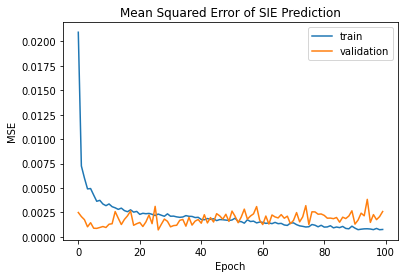

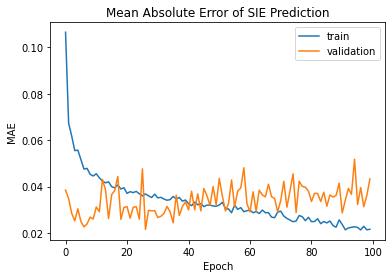

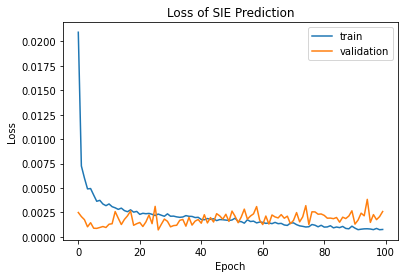

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

45/45 [==============================] - 1s 3ms/step


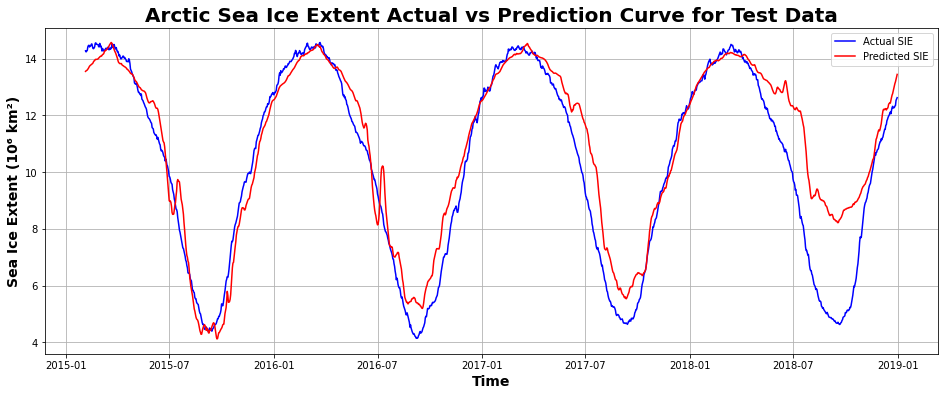

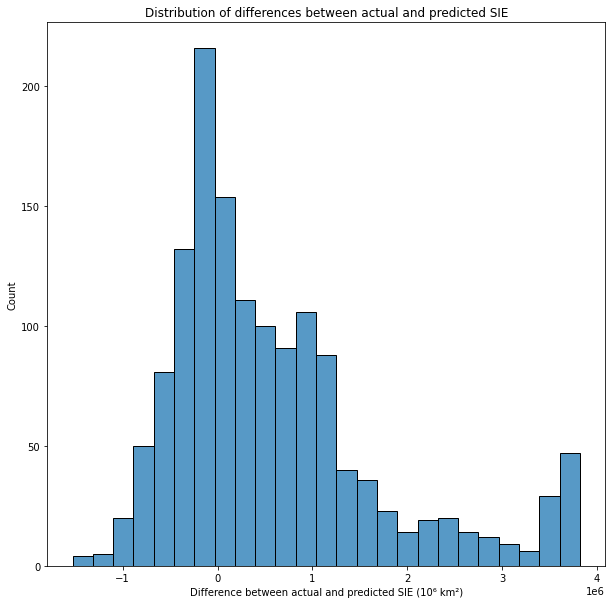

MSE :  1576554381189.468 (10⁶ km²)
MSPE : 4.13714569624208 %
RMSE :  1255609.167372343 (10⁶ km²)
RMSPE : 20.339974671179117 %
MAE :  848232.6820252277 (10⁶ km²)
MAPE :  9.207267037914598 %
R2 :  0.8229635436525745


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [14]:
# while True:pass